# Filtrado de mensajes spam

## Descripción del problema real

La recepción de publicidad no deseada a traves mensajes de texto usando SMS (Short Message Service) es un problema que afecta a muchos usuarios de teléfonos móviles. El problema radica en que los usuarios deben pagar por los mesajes recibidos, y por este motivo resulta muy importante que las compañías prestadoras del servicio puedan filtrar mensajes indeseados antes de enviarlos a su destinatario final. Los mensajes tienen una longitud máxima de 160 caracteres, por lo que el texto resulta poco para realizar la clasificación, en comparación con textos más largos (como los emails). Adicionalmente, los errores de digitación dificultan el proceso de detección automática.

## Descripción del problema en términos de los datos

Se tiene una muestra contiene 5574 mensajes en inglés, no codificados y clasificados como legítimos (ham) o spam (http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/). La información está almacenada en el archivo `datos/spam-sms.zip`.El problema en términos de los datos consiste en clasificar si un mensaje SMS es legítico o spam, a partir del análisis de las palabras que contiente, partiendo del supuesto de que ciertas palabras que son más frecuentes dependiendo del tipo de mensaje. Esto implica que en la fase de preparación de los datos se deben extraer las palabras que contiene cada mensaje para poder realizar el análsis.

## Aproximaciones posibles

En este caso, se desea comparar los resultados de un modelo de redes neuronales artificiales y otras técnicas estadísticas para realizar la clasificación.

## Requerimientos

Usted debe:

* Preprocesar los datos para representarlos usando bag-of-words.


* Construir un modelo de regresión logística como punto base para la comparación con otros modelos más complejos.


* Construir un modelo de redes neuronales artificiales. Asimismo, debe determinar el número de neuronas en la capa o capas ocultas.


* Utiizar una técnica como crossvalidation u otra similar para establecer la robustez del modelo.


* Presentar métricas de desempeño para establecer las bondades y falencias de cada clasificador.

---

# Solución

In [0]:
import pandas as pd
import glob
import email
import re
import nltk
import sklearn

In [0]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('words')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

Creamos todas las funciones que serviran para la limpieza de los mensajes de texto

In [0]:
def _remove_html_tags(text):
    return re.sub("<[^>]*>", "", text)

def _remove_websites(text):
    """
    este regex fue obtenido de: https://daringfireball.net/2010/07/improved_regex_for_matching_urls
    """
    regex = r'\b((?:[a-z][\w-]+:(?:\/{1,3}|[a-z0-9%])|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}\/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'\".,<>?«»“”‘’]))'
    return re.sub(regex, "", text)

def _remove_emails(text):
    return re.sub("[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.].+", "", text)

def _lowercase_all(text):
    return text.lower()

def _remove_special_characters(text):
    return re.sub("[^A-Za-z0-9]+", " ", text)

def _remove_numbers(text):
    return re.sub("[0-9]+", "", text)

def _remove_single_letters(text):
    words_list = text.split()
    clean_text_words = []
    for word in words_list:
        if len(word) > 1:
            clean_text_words.append(word)
    return " ".join(clean_text_words)

def _lemmatization_of_words(text):    
    from nltk.stem.porter import PorterStemmer
    clean_text_words = []
    porter = PorterStemmer()
    sentence_words = nltk.word_tokenize(text)
    
    for word in sentence_words:
        clean_text_words.append(porter.stem(word))
    
    return " ".join(clean_text_words)

def _remove_stop_words(text):
    from nltk.corpus import stopwords
    
    stop_words = set(stopwords.words('english'))
    words = nltk.word_tokenize(text)
    words_filtered = []

    for word in words:
        if word not in stop_words:
            words_filtered.append(word)
    
    return " ".join(words_filtered)

def _remove_nonsense_words(text):
    from nltk.corpus import words
    words = set(words.words())
    
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w in words)


Se ha construido un data pipeline para limpiar el cuerpo del mensaje, los pasos que sigue este método para la limpieza son los siguientes:
* Eliminar etiquetas HTML en el cuerpo del mensaje en caso de que existan
* Eliminar websites que aparezcan en el mensaje
* Eliminar correos electronicos en el cuerpo del mensaje
* Pasar todo el texto a minúsculas
* Eliminar los carácteres numéricos
* Eliminar los carácteres especiales (*/+=:,. entre otros)
* Eliminar las letras que no hacen parte de una palabra (esto sucede porque después de eliminar caracteres especiales de palabras como "it's", el texto queda como "it s")
* Eliminación de palabras vacías
* Eliminación de palabras sin sentido (palabras inexistentes)
* Lematizar las palabras (reducirlas a su base lingüistica)

In [0]:
def _clean_body_message(body):
    message_without_html_tags = _remove_html_tags(body)

    message_without_websites = _remove_websites(message_without_html_tags)

    message_without_emails = _remove_emails(message_without_websites)

    message_lowercase = _lowercase_all(message_without_emails)

    message_without_numbers = _remove_numbers(message_lowercase)

    message_without_special_characters = _remove_special_characters(message_without_numbers)
    
    message_without_single_letters = _remove_single_letters(message_without_special_characters)
    
    message_without_stop_words = _remove_stop_words(message_without_single_letters)
    
    message_with_correct_words = _remove_nonsense_words(message_without_stop_words)
    
    clean_message = _lemmatization_of_words(message_with_correct_words)
    
    return clean_message

\_get_body_message() es la función que nos servirá para obtener unicamente el cuerpo del mensaje

In [0]:
def _get_body_message(all_message):
    b = email.message_from_string(all_message)
    body = ""

    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload()  # decode
                break
    else:
        body = b.get_payload()
    
    return _clean_body_message(body)

In [0]:
def preprocess_files(files):
    mail_body_messages = []
    for filename in files:
        with open(filename, 'rt', encoding = "ISO-8859-1") as f:
            body_message = _get_body_message(f.read())
            if len(body_message) > 0: # Eliminacion de mensajes que quedaron vacios despues de preprocesamiento
                mail_body_messages.append(body_message)
    return mail_body_messages

In [0]:
first_easy_ham_files = glob.glob("datos/spam-filter/easy_ham/0*")
second_easy_ham_files = glob.glob("datos/spam-filter/easy_ham_2/0*")
first_hard_ham_files = glob.glob("datos/spam-filter/hard_ham/0*")
second_hard_ham_files = glob.glob("datos/spam-filter/hard_ham_2/0*")
first_spam_files = glob.glob("datos/spam-filter/spam/0*")
second_spam_files = glob.glob("datos/spam-filter/spam_2/0*")

first_easy_ham_messages = preprocess_files(first_easy_ham_files)
second_easy_ham_messages = preprocess_files(second_easy_ham_files)
first_hard_ham_messages = preprocess_files(first_hard_ham_files)
second_hard_ham_messages = preprocess_files(second_hard_ham_files)
first_spam_messages = preprocess_files(first_spam_files)
second_spam_messages = preprocess_files(second_spam_files)

Obtengamos los tres primeros mensajes de first_easy_ham_messages para ver como quedaron los mensajes después de haber pasado por las funciones de preprocesamiento.

In [0]:
first_easy_ham_messages[:3]

['vincent wrote hello look packag anyon know get tri compil error messag work spec file dirti clean think build instal sort need pleas tri net help let know list list',
 'wed wrote wed stephan wrote face similar problem tri instal fresh defin given order latest file spec modul get use good hear mind tell set specificli tri shell well insid even command line success presum run bash note directori map print set shell variabl variabl put futur use export tri instal man inform stephan intern remembr talk list',
 'date mobil danger phone mobil link discuss via hack planet']

Creamos el método que procesará los datos con el modelo de Bag Of Words, además, este método retornará un dataframe de Pandas con la variable categorica en 1 si los mensajes son categorizados como spam o 0 si no lo son.

In [0]:
def get_bag_of_words_dataset(files, is_spam_files):    
    from sklearn.feature_extraction.text import CountVectorizer
    vectorizer = CountVectorizer()
    bag_of_words = vectorizer.fit_transform(files).todense()
    dataframe = pd.DataFrame(bag_of_words, columns=vectorizer.get_feature_names())
    
    if is_spam_files:
        dataframe['spam'] = 1
    else:
        dataframe['spam'] = 0
        
    return dataframe

In [0]:
first_easy_ham_dataset = get_bag_of_words_dataset(first_easy_ham_messages, False)
second_easy_ham_dataset = get_bag_of_words_dataset(second_easy_ham_messages, False)
first_hard_ham_dataset = get_bag_of_words_dataset(first_hard_ham_messages, False)
second_hard_ham_dataset = get_bag_of_words_dataset(second_hard_ham_messages, False)
first_spam_dataset = get_bag_of_words_dataset(first_spam_messages, True)
second_spam_dataset = get_bag_of_words_dataset(second_spam_messages, True)

Usemos el método head() de Pandas para ver como quedaron nuestros dataframes después de pasar por el modelo de Bag Of Words, tomaremos también un dataset que no es spam y otro que si para asegurarnos que la categoria spam quedo asignada correctamente.

In [0]:
second_hard_ham_dataset.head()

,aa,aardvark,abandon,abba,abbrevi,abduct,abil,abl,abod,abound,...,yummi,zealot,zenith,zero,zig,zip,zone,zoom,zorro,spam
0,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
first_spam_dataset.head()

,aa,abandon,abat,abid,abil,abl,abnorm,aborigin,abroad,absenc,...,young,younger,youth,za,zero,zimbabw,zip,zone,zowi,spam
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


Agruparemos todos los dataframes en uno sólo con la finalidad de dividir más adelante el dataset en uno de entrenamiento y otro de validación tomando los datos de forma aleatoria.

In [0]:
all_df= [first_easy_ham_dataset, second_easy_ham_dataset, first_hard_ham_dataset,
        second_hard_ham_dataset, first_spam_dataset, second_spam_dataset]
spam_df = pd.concat(all_df, axis=0, ignore_index=True)

ahora observaremos un heatmap de los valores nulos en el dataset puesto que después de la agrupación esto puede ocurrirle a los valores de las columnas que no existian en otro dataset, es decir, si una palabra no existia en un dataset, al agruparse con otro, los valores que tomará serán nulos en vez de cero.

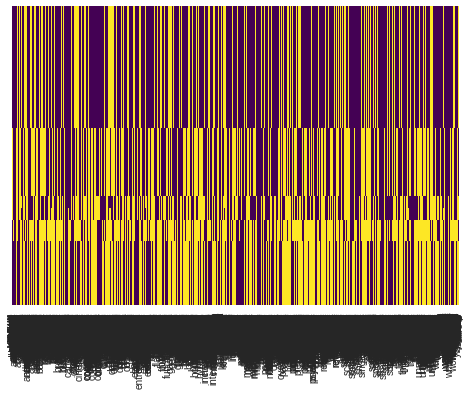

In [0]:
import seaborn as sns
sns.heatmap(spam_df.isna(),yticklabels=False,cbar=False,cmap='viridis')

El color amarillo en el heatmap representa los valores nulos en el dataset, a continuación observaremos una muestra de cuantos valores nulos hay en cada columna.

In [0]:
print(spam_df.isna().sum())

aa             0
aardvark    5678
abandon        0
abat        4390
abba        5678
abbey       3671
abbrevi     5678
abdomin     3671
abduct      4279
aberr       3671
abhorr      4771
abid        1819
abil           0
abject      2272
abl            0
abli        4843
abneg       4843
abnorm      2991
aboard      2344
abod        4279
abolish     3671
abolit      3671
aborigin    1891
abort        945
abound      1780
abreast     4351
abridg      3671
abroad       246
abruptli    4771
abscond     4843
            ... 
yorker      3671
young          0
younger        0
youth          0
yr           945
yuck        3671
yucki       3444
yummi       5678
za          2991
zeal        4771
zealot      1780
zealou      2272
zebra       3671
zed         3671
zee         4771
zenith      5678
zero           0
zest        4843
zeta        3671
zig         5678
zimbabw      492
zinc        4843
zip            0
zodiac      3671
zombi       5924
zone           0
zoo         2272
zoom        42

El dataset no se puede dejar con esos valores nulos, por lo que procederemos a llenar esos valores con ceros y veremos de nuevo el heatmap.

In [0]:
spam_df = spam_df.fillna(value=0)

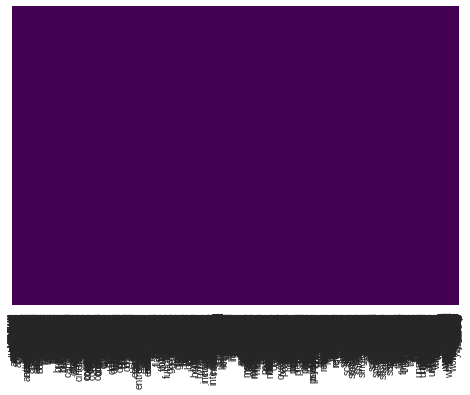

In [0]:
sns.heatmap(spam_df.isna(),yticklabels=False,cbar=False,cmap='viridis')

Podemos observar que ya no existe ningún valor nulo en el dataset.

Ahora, teniendo en cuenta que la red neuronal da mejores resultados con valores entre 0 y 1 procedemos a normalizar el los valores del dataset exceptuando la variable categorica (spam)

In [0]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(spam_df.drop('spam', axis=1))

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)


StandardScaler(copy=True, with_mean=True, with_std=True)

In [0]:
scaled_features = scaler.transform(spam_df.drop('spam',axis=1))
df_feat = pd.DataFrame(scaled_features,columns=spam_df.columns.drop('spam'))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  """Entry point for launching an IPython kernel.


In [0]:
df_feat.shape

(6170, 12246)

# Train test split

Procedemos a dividir nuestro dataset en datasets de entrenamiento y validación, obteniendo una muestra aleatoria del 70% de datos para entrenamiento y 30% para validación.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(scaled_features, 
                                                    spam_df['spam'], test_size=0.30)

# Regresión Logística

A continuación usaremos el modelo de regresión logística de la librería Scikit learn, lo entrenaremos con nuestro dataset de entrenamiento.

In [0]:
from sklearn.linear_model import LogisticRegression
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Ahora que el modelo de regresión logística se ha entrenado, vamos a hacer predicciones pero con los features del dataset de validación, hay que tener en cuenta que este dataset es completamente desconocido para nuestro modelo de regresión logistica, además, desconoce los resultados.

In [0]:
predictions = logmodel.predict(X_test)

# Métricas

Teniendo las predicciones hechas con nuestro dataset de validación, vamos a comparar estas predicciones con los valores reales del dataset de validación, es decir, con la variable categorica del dataset. 

Para hacer esta comparación usaremos dos métricas alojadas en la librería Scikit Learn, una de ellas es el reporte de clasificación que nos dará una idea del rendimiento y la precisión que obtuvo nuestro modelo de regresión logistica cuando comparamos las predicciones del modelo con los valores reales.

Otra métrica que usaremos será la matriz de confusión para darnos una idea de cuandos falsos positivos y falsos negativos tuvo las predicciones de nuestro modelo.

In [0]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.99      0.91      0.95      1318
           1       0.81      0.97      0.88       533

   micro avg       0.93      0.93      0.93      1851
   macro avg       0.90      0.94      0.92      1851
weighted avg       0.94      0.93      0.93      1851



In [0]:
print(confusion_matrix(y_test, predictions))

[[1201  117]
 [  18  515]]


Podemos observar que nuestro modelo obtuvo una precisión del 94% con 117 falsos positivos y 18 falsos negativos.

# Redes Neuronales

Para la creación de la red neuronal usaremos Keras.

La red neuronal que haremos será un perceptrón multicapa con una sóla capa oculta, ésta consta de:

* Una capa de entrada con 12246 neuronas, una para cada feature del dataset.
* Una capa oculta con una cantidad de neuronas que vamos a variar y de las cuales vamos a obtener métricas, los posibles valores a tener en cuenta serán [32, 2064, 6124, 12246]
* Una capa de salida con 2 neuronas de salida, uno por cada categoria (1 si es spam y 0 si no lo es). Esto porque usaremos softmax como función de activación

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [0]:
def print_history(fitted_model, units):
    plt.plot(fitted_model.history['acc'])
    plt.plot(fitted_model.history['val_acc'])
    plt.title('Precision del modelo con {} unidades'.format(units))
    plt.ylabel('Precisión')
    plt.xlabel('Epoch')
    plt.legend(['Entrenamiento', 'Validación'], loc='lower right')
    plt.show()

In [0]:
import keras

num_classes = 2

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Using TensorFlow backend.


In [0]:
from keras.layers import Dense # Capa de red neuronal regular
from keras.models import Sequential # Configura el modelo para el entrenamiento

number_of_features = df_feat.shape[1]
quantity_of_units = [32, 2064, 6124, number_of_features] # Diferentes valores de unit para evaluar el modelo

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4319 samples, validate on 1851 samples
Epoch 1/50
4319/4319 [==============================] - 2s 438us/step - loss: 0.5012 - acc: 0.8488 - val_loss: 0.8186 - val_acc: 0.8487
Epoch 2/50
4319/4319 [==============================] - 1s 128us/step - loss: 0.2262 - acc: 0.9692 - val_loss: 0.9465 - val_acc: 0.8709
Epoch 3/50
4319/4319 [==============================] - 1s 126us/step - loss: 0.1667 - acc: 0.9843 - val_loss: 0.9190 - val_acc: 0.8709
Epoch 4/50
4319/4319 [==============================] - 1s 124us/step - loss: 0.1582 - acc: 0.9873 - val_loss: 0.9179 - val_acc: 0.8725
Epoch 5/50
4319/4319 [==============================] - 0s 114us/step - loss: 0.1549 - acc: 0.9875 - val_loss: 0.9191 - val_acc: 0.8736
Epoch 6/50
4319/4319 [==============================] - 0s 116us/step - loss: 0.1522 - acc: 0.9882 - val_loss: 0.9177 - val_acc: 0.8736
Epoch 7/50
4319/

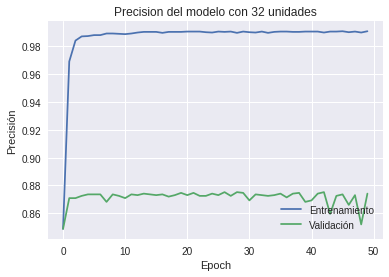

Train on 4319 samples, validate on 1851 samples
Epoch 1/50
4319/4319 [==============================] - 2s 572us/step - loss: 0.4553 - acc: 0.8861 - val_loss: 0.2380 - val_acc: 0.9508
Epoch 2/50
4319/4319 [==============================] - 2s 394us/step - loss: 0.2855 - acc: 0.9680 - val_loss: 0.2761 - val_acc: 0.9611
Epoch 3/50
4319/4319 [==============================] - 2s 394us/step - loss: 0.1521 - acc: 0.9829 - val_loss: 0.2770 - val_acc: 0.9665
Epoch 4/50
4319/4319 [==============================] - 2s 397us/step - loss: 0.0504 - acc: 0.9942 - val_loss: 0.2654 - val_acc: 0.9622
Epoch 5/50
4319/4319 [==============================] - 2s 397us/step - loss: 0.0448 - acc: 0.9940 - val_loss: 0.2227 - val_acc: 0.9692
Epoch 6/50
4319/4319 [==============================] - 2s 397us/step - loss: 0.0309 - acc: 0.9970 - val_loss: 0.2375 - val_acc: 0.9692
Epoch 7/50
4319/4319 [==============================] - 2s 393us/step - loss: 0.0308 - acc: 0.9970 - val_loss: 0.2316 - val_acc: 0.9681


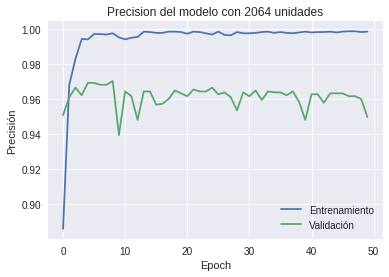

Train on 4319 samples, validate on 1851 samples
Epoch 1/50
4319/4319 [==============================] - 6s 1ms/step - loss: 0.8289 - acc: 0.8493 - val_loss: 0.3674 - val_acc: 0.9379
Epoch 2/50
4319/4319 [==============================] - 4s 921us/step - loss: 0.3796 - acc: 0.9611 - val_loss: 1.2833 - val_acc: 0.8801
Epoch 3/50
4319/4319 [==============================] - 4s 918us/step - loss: 0.3246 - acc: 0.9667 - val_loss: 0.4420 - val_acc: 0.9552
Epoch 4/50
4319/4319 [==============================] - 4s 916us/step - loss: 0.1982 - acc: 0.9850 - val_loss: 0.3631 - val_acc: 0.9600
Epoch 5/50
4319/4319 [==============================] - 4s 918us/step - loss: 0.1712 - acc: 0.9868 - val_loss: 0.3148 - val_acc: 0.9633
Epoch 6/50
4319/4319 [==============================] - 4s 917us/step - loss: 0.1296 - acc: 0.9900 - val_loss: 0.3036 - val_acc: 0.9633
Epoch 7/50
4319/4319 [==============================] - 4s 919us/step - loss: 0.1137 - acc: 0.9914 - val_loss: 0.3077 - val_acc: 0.9622
Ep

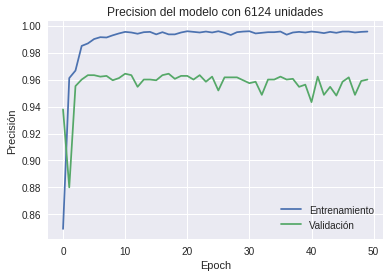

Train on 4319 samples, validate on 1851 samples
Epoch 1/50
4319/4319 [==============================] - 11s 3ms/step - loss: 2.7046 - acc: 0.7504 - val_loss: 0.5653 - val_acc: 0.8838
Epoch 2/50
4319/4319 [==============================] - 7s 2ms/step - loss: 0.3607 - acc: 0.9447 - val_loss: 0.2703 - val_acc: 0.9643
Epoch 3/50
4319/4319 [==============================] - 7s 2ms/step - loss: 0.2003 - acc: 0.9794 - val_loss: 0.2764 - val_acc: 0.9660
Epoch 4/50
4319/4319 [==============================] - 7s 2ms/step - loss: 0.1766 - acc: 0.9868 - val_loss: 0.3034 - val_acc: 0.9670
Epoch 5/50
4319/4319 [==============================] - 7s 2ms/step - loss: 0.1853 - acc: 0.9870 - val_loss: 0.3118 - val_acc: 0.9627
Epoch 6/50
4319/4319 [==============================] - 7s 2ms/step - loss: 0.1866 - acc: 0.9870 - val_loss: 0.3239 - val_acc: 0.9562
Epoch 7/50
4319/4319 [==============================] - 7s 2ms/step - loss: 0.1875 - acc: 0.9856 - val_loss: 0.3022 - val_acc: 0.9649
Epoch 8/50
43

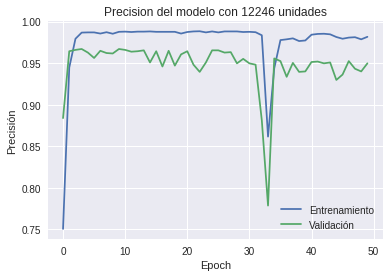

In [0]:
for units in quantity_of_units:
    model=Sequential()
    model.add(Dense(units, input_dim=number_of_features, activation='relu'))
    keras.layers.core.Dropout(rate=0.4) # Creamos una capa oculta para regularizar y evitar sobre-entrenamientos
    model.add(Dense(num_classes,input_dim=number_of_features,activation='softmax')) # Creamos la capa de salida

    # Vamos a usar el optimizador adam para compilar el modelo y vamos a usar la precisión como metrica
    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

    # Entrenamos el modelo y hacemos la validación
    fit_history = model.fit(X_train,y_train,epochs=50,batch_size=128,validation_data=(X_test,y_test))
    print_history(fit_history, units) # Graficamos la precisión a lo largo del entrenamiento

Se puede observar que bajo toda cantidad de neuronas en la capa oculta los modelos se trataron de ajustar a la curva de set de entrenamiento, sin embargo la que mostró un mejor porcentaje de precisión a lo largo de los epochs fue la capa oculta con 6124 neuronas llegando a tener un promedio de un 96% de precisión.

Comparando la red neuronal con 6124 neuronas en la capa oculta y la regresión logística, también se obtuvo una mayor precisión en la red neuronal (96%) Vs. la regresión logística (94%) para la clasificación de mensajes de spam.